  # ACEpotentials.jl Tutorial

  ## Introduction

  The `ACEpotentials.jl` documentation
  (https://acesuit.github.io/ACEpotentials.jl/) contains a number of short,
  focused tutorials on key topics. This tutorial is longer and has a single
  narrative. Many Julia commands are introduced by example.

  ### Installing ACEpotentials

  `ACEpotentials` version 0.8 and above requires Julia 1.10. For detailed
  installation instructions, see:
  https://acesuit.github.io/ACEpotentials.jl/dev/gettingstarted/installation/.

  Warning: The following installation may take several minutes.

add and load general packages used in this notebook.

In [34]:
using Pkg
# Uncomment the next line if installing Julia for the first time
# Pkg.Registry.add("General")
Pkg.activate("..")
Pkg.add(["LaTeXStrings", "MultivariateStats", "Plots", "PrettyTables",
         "Suppressor", "ExtXYZ", "Unitful", "Distributed", "AtomsCalculators",
         ])

# ACEpotentials installation:
# If ACEpotentials has not been installed yet, uncomment the following lines
# using Pkg; Pkg.activate(".")
# Add the ACE registry, which stores the ACEpotential package information
# Pkg.Registry.add(RegistrySpec(url="https://github.com/ACEsuit/ACEregistry"))
# Pkg.add("ACEpotentials")

  Activating project at `~/Documents/GitHub-2/ACESIDopt.jl`
   Resolving package versions...
      Compat entries added for 
  No Changes to `~/Documents/GitHub-2/ACESIDopt.jl/Project.toml`
  No Changes to `~/Documents/GitHub-2/ACESIDopt.jl/Manifest.toml`
Precompiling project...
   8480.2 ms  ✓ ACESIDopt
  1 dependency successfully precompiled in 11 seconds. 574 already precompiled.


  We can check the status of the installed packages.

In [35]:
using Pkg; Pkg.activate("..")
Pkg.status()

Project ACESIDopt v0.1.0
Status `~/Documents/GitHub-2/ACESIDopt.jl/Project.toml`
  [ad31a8ef] ACEfit v0.3.0
  [3b96b61c] ACEpotentials v0.10.1
  [3da9722f] ASEconvert v0.2.0
  [a963bdd2] AtomsBase v0.5.2
  [f5cc8831] AtomsBuilder v0.2.3
  [a3e0e189] AtomsCalculators v0.2.3
  [9855a07e] AtomsCalculatorsUtilities v0.1.8
  [31c24e10] Distributions v0.25.123
  [352459e4] ExtXYZ v0.2.2
⌃ [7073ff75] IJulia v1.33.0
  [b964fa9f] LaTeXStrings v1.4.0
  [98b081ad] Literate v2.21.0
⌃ [add582a8] MLJ v0.19.2
  [5ae90465] MLJScikitLearnInterface v0.7.0
⌅ [aa0f7f06] Molly v0.22.3
  [6f286f6a] MultivariateStats v0.10.3
  [91a5bcdd] Plots v1.41.4
⌅ [08abe8d2] PrettyTables v2.4.0
  [49802e3a] ProgressBars v1.5.1
  [92933f4c] ProgressMeter v1.11.0
  [6099a3de] PythonCall v0.9.31
  [90137ffa] StaticArrays v1.9.16
  [f3b207a7] StatsPlots v0.15.8
  [fd094767] Suppressor v0.2.8
  [1986cc42] Unitful v1.27.0
  [8ba89e20] Distributed v1.11.0
  [37e2e46d] LinearAlgebra v1.11.0
Info Packages marked with ⌃ and ⌅ ha

  Activating project at `~/Documents/GitHub-2/ACESIDopt.jl`


  Import all the packages that we will be using.

In [36]:
using LaTeXStrings, MultivariateStats, Plots, PrettyTables, Printf,
      Statistics, Suppressor, ExtXYZ, Unitful

using ACEpotentials

  ## Part 1: Basic dataset analysis

  `ACEpotentials` provides quick access to several example datasets, which can
  be useful for testing. The following command lists these datasets. (We
  expect to expand this list signifcantly; please feel free to suggest
  additions.)

In [37]:
ACEpotentials.list_example_datasets()

9-element Vector{String}:
 "Si_tiny"
 "TiAl_tiny"
 "TiAl_tutorial"
 "Zuo20_Cu"
 "Zuo20_Ge"
 "Zuo20_Li"
 "Zuo20_Mo"
 "Zuo20_Ni"
 "Zuo20_Si"

  We begin by loading the tiny silicon dataset.

In [38]:
Si_sub_data,  _, _ = ACEpotentials.example_dataset("Si_tiny");

  These data were taken from a larger set published with:
  > A. P. Bartók, J. Kermode, N. Bernstein, and G. Csányi, **Machine Learning a General-Purpose Interatomic Potential for Silicon**, Phys. Rev. X 8, 041048 (2018)

  To illustrate the procedure for loading extended xyz data from a file, we
  download the larger dataset and load it.

In [39]:
if !isfile("Si_dataset.xyz")
    download("https://www.dropbox.com/scl/fi/z6lvcpx3djp775zenz032/Si-PRX-2018.xyz?rlkey=ja5e9z99c3ta1ugra5ayq5lcv&st=cs6g7vbu&dl=1",
         "Si_dataset.xyz");
end

Si_dataset = ExtXYZ.load("Si_dataset.xyz");

# The last command generates a warning referring to missing pbc in the
# first structure in the dataset, the isolated atom. We can safely remove this.
deleteat!(Si_dataset, 1);

┌ Warning: 'pbc' not contained in dict. Defaulting to all-periodic boundary. 
└ @ ExtXYZ /Users/msachs2/.julia/packages/ExtXYZ/LO7ur/src/atoms.jl:156


  Next, we assess the dataset sizes.

In [40]:
println("The tiny dataset has ", length(Si_sub_data), " structures.")
println("The large dataset has ", length(Si_dataset), " structures.")

The tiny dataset has 53 structures.
The large dataset has 2474 structures.


  Next, we create arrays containing the config_type for each structure in the
  datasets. Afterwards, we count the configurations of each type.

In [41]:
config_types_tiny = [at[:config_type] for at in Si_sub_data]
config_types = [ at[:config_type] for at in Si_dataset]

function count_configs(config_types)
    config_counts = [sum(config_types .== ct) for ct in unique(config_types)]
    config_dict = Dict([ct=>cc for (ct,cc) in zip(unique(config_types), config_counts)])
end;

println("There are ", length(unique(config_types_tiny)),
        " unique config_types in the tiny dataset:")
display(count_configs(config_types_tiny))

println("There are ", length(unique(config_types)),
        " unique config_types in the full dataset:")
display(count_configs(config_types))

Dict{String, Int64} with 4 entries:
  "isolated_atom" => 1
  "dia"           => 25
  "liq"           => 2
  "bt"            => 25

Dict{String, Int64} with 26 entries:
  "sh"                  => 223
  "vacancy"             => 211
  "surface_110"         => 26
  "sp2"                 => 51
  "fcc"                 => 49
  "bt"                  => 445
  "crack_110_1-10"      => 7
  "dia"                 => 489
  "divacancy"           => 78
  "interstitial"        => 115
  "hcp"                 => 49
  "surface_111_3x3_das" => 1
  "amorph"              => 159
  "decohesion"          => 33
  "111adatom"           => 11
  "sp"                  => 100
  "liq"                 => 76
  "surface_001"         => 29
  "bc8"                 => 49
  ⋮                     => ⋮

There are 4 unique config_types in the tiny dataset:
There are 26 unique config_types in the full dataset:


In [42]:
amorphous_indices = [i for (i,at) in enumerate(Si_dataset) if at[:config_type] == "amorph"]

159-element Vector{Int64}:
 1234
 1235
 1236
 1237
 1238
 1239
 1240
 1241
 1242
 1243
    ⋮
 1384
 1385
 1386
 1387
 1388
 1389
 1390
 1391
 1392

In [43]:
for a in unique(config_types)
    println(a, ", ", count_configs(config_types)[a])
end
struct_sizes = unique([length(at) for at in Si_dataset[amorphous_indices]])
for s in struct_sizes
    println("Number of amorphous structures with ", s, " atoms: ",
            sum([length(at) == s for at in Si_dataset[amorphous_indices]]))
end

Si_amorph = Si_dataset[amorphous_indices];
println("The amorphous subset has ", length(Si_amorph), " structures.")


sh, 223
dia, 489
bt, 445
liq, 76
amorph, 159
surface_001, 29
surface_110, 26
surface_111, 47
surface_111_pandey, 50
crack_110_1-10, 7
crack_111_1-10, 10
sp, 100
sp2, 51
interstitial, 115
screw_disloc, 19
divacancy, 78
vacancy, 211
111adatom, 11
surface_111_3x3_das, 1
decohesion, 33
bc8, 49
bcc, 49
fcc, 49
hcp, 49
hex_diamond, 49
st12, 49
Number of amorphous structures with 64 atoms: 31
Number of amorphous structures with 216 atoms: 128
The amorphous subset has 159 structures.


In [44]:
typeof(Si_sub_data)
typeof(Si_sub_data[1])

Atoms{@NamedTuple{species::Vector{AtomsBase.ChemicalSpecies}, n_neighb::Vector{Int32}, atomic_number::Vector{Int64}, position::Vector{Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(Å,), 𝐋, nothing}}}}, map_shift::Vector{Vector{Int32}}, gap_force::Vector{Vector{Float64}}, dft_force::Vector{Vector{Float64}}, mass::Vector{Quantity{Float64, 𝐌, Unitful.FreeUnits{(u,), 𝐌, nothing}}}, atomic_symbol::Vector{Symbol}, velocity::Vector{Vector{Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(u⁻¹ᐟ², eV¹ᐟ²), 𝐋 𝐓⁻¹, nothing}}}}}, @NamedTuple{nneightol::Float64, dft_energy::Float64, cutoff::Float64, gap_virial::Matrix{Float64}, periodicity::Tuple{Bool, Bool, Bool}, config_type::String, gap_energy::Float64, cell_vectors::Vector{Vector{Quantity{Float64, 𝐋, Unitful.FreeUnits{(Å,), 𝐋, nothing}}}}}}

  Two basic distributions which indicate how well the data fills space are the
  radial and angular distribution functions. We begin with the radial
  distribution function, plotting using the histogram function in Plots.jl.
  For the RDF we add some vertical lines to indicate the distances and first,
  second neighbours and so forth to confirm that the peaks are in the right
  place.

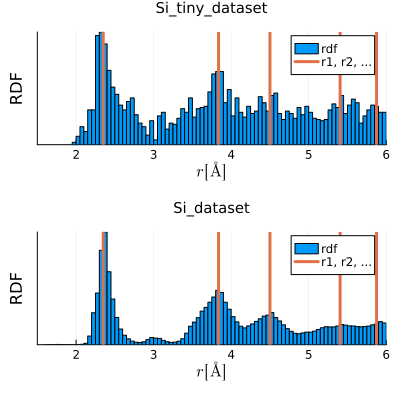

In [45]:
r_cut = 6.0u"Å"
rnn = 2.35

rdf_tiny = ACEpotentials.get_rdf(Si_sub_data,  r_cut; rescale = true)
plt_rdf_1 = histogram(rdf_tiny[(:Si, :Si)], bins=150, label = "rdf",
                      title="Si_tiny_dataset", titlefontsize=10,
                      xlabel = L"r[\AA]", ylabel = "RDF", yticks = [],
                      xlims=(1.5,6), size=(400,200), left_margin = 2Plots.mm)
vline!(rnn * [1.0, 1.633, 1.915, 2.3, 2.5], label = "r1, r2, ...", lw=3)

rdf = ACEpotentials.get_rdf(Si_dataset, r_cut; rescale = true);
plt_rdf_2 = histogram(rdf[(:Si, :Si)], bins=150, label = "rdf",
                      title="Si_dataset", titlefontsize=10,
                      xlabel = L"r[\AA]", ylabel = "RDF", yticks = [],
                      xlims=(1.5,6), size=(400,200), left_margin = 2Plots.mm)
vline!(rnn * [1.0, 1.633, 1.915, 2.3, 2.5], label = "r1, r2, ...", lw=3)

plot(plt_rdf_1, plt_rdf_2, layout=(2,1), size=(400,400))

  The larger dataset clearly has a better-converged radial distribution
  function. (But also a much larger ratio between high and low distribution
  regions.)

  For the angular distribution function, we use a cutoff just above the
  nearest-neighbour distance so we can clearly see the equilibrium
  bond-angles. In this case, the vertical line indicates the equilibrium bond
  angle.

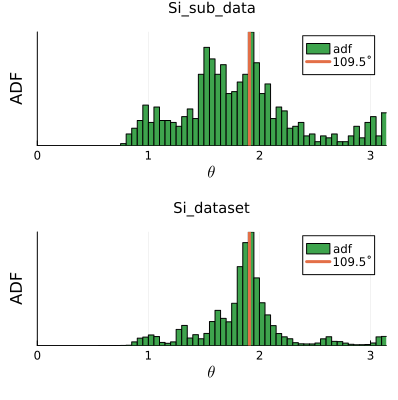

In [46]:
r_cut_adf = 1.25 * rnn * u"Å"
eq_angle = 1.91 # radians
adf_tiny = ACEpotentials.get_adf(Si_sub_data,  r_cut_adf);
plt_adf_1 = histogram(adf_tiny, bins=50, label = "adf", yticks = [], c = 3,
                    title = "Si_sub_data", titlefontsize = 10,
                    xlabel = L"\theta", ylabel = "ADF",
                    xlims = (0, π), size=(400,200), left_margin = 2Plots.mm)
vline!([ eq_angle,], label = "109.5˚", lw=3)

adf = ACEpotentials.get_adf(Si_dataset, r_cut_adf);
plt_adf_2 = histogram(adf, bins=50, label = "adf", yticks = [], c = 3,
                    title = "Si_dataset", titlefontsize = 10,
                    xlabel = L"\theta", ylabel = "ADF",
                    xlims = (0, π), size=(400,200), left_margin = 2Plots.mm)
vline!([ eq_angle,], label = "109.5˚", lw=3)

plot(plt_adf_1, plt_adf_2, layout=(2,1), size=(400,400))

  For later use, we define a function that extracts the energies stored in the
  silicon datasets.

In [47]:
function extract_energies(dataset)
    energies = []
    for atoms in dataset
        for key in keys(atoms)
            if lowercase(String(key)) == "dft_energy"
                push!(energies, atoms[key] / length(atoms))
            end
        end
    end
    return energies
end;

Si_dataset_energies = extract_energies(Si_dataset)
;  # the ; is just to suppress the ouput

  ## Part 2: ACE descriptors

  An ACE basis specifies a vector of invariant features of atomic environments
  and can therefore be used as a general descriptor.

  Some important parameters include:
  -  elements: list of chemical species, as symbols;
  -  order: correlation/interaction order (body order - 1);
  -  totaldegree: maximum total polynomial degree used for the basis;
  -  rcut : cutoff radius (optional, defaults are provided).

In [48]:
model = ace1_model(elements = [:Si],
                   rcut = 5.5,
                   order = 3,        # body-order - 1
                   totaldegree = 8 );

  As an example, we compute an averaged structural descriptor for each
  configuration in the tiny dataset.

In [49]:
descriptors = []
for system in Si_sub_data
    struct_descriptor = sum(site_descriptors(system, model)) / length(system)
    push!(descriptors, struct_descriptor)
end

  Next, we extract and plot the principal components of the structural
  descriptors. Note the segregation by configuration type.

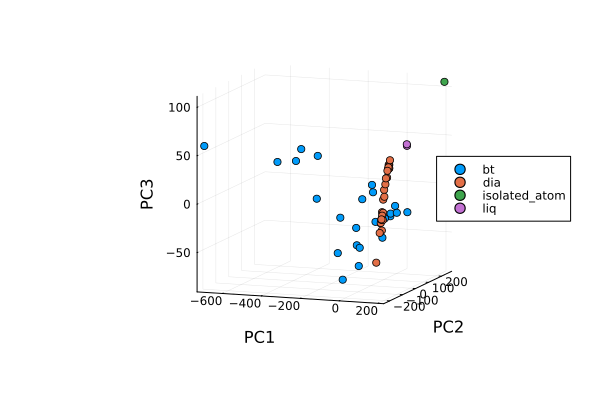

In [50]:
descriptors = reduce(hcat, descriptors)  # convert to matrix
M = fit(PCA, descriptors; maxoutdim=3, pratio=1)
descriptors_trans = transform(M, descriptors)
p = scatter(
     descriptors_trans[1,:], descriptors_trans[2,:], descriptors_trans[3,:],
     marker=:circle, linewidth=0, group=config_types_tiny, legend=:right)
plot!(p, xlabel="PC1", ylabel="PC2", zlabel="PC3", camera=(20,10))

  Finally, we repeat the procedure for the full dataset. Some clustering is
  apparent, although the results are a bit harder to interpret.

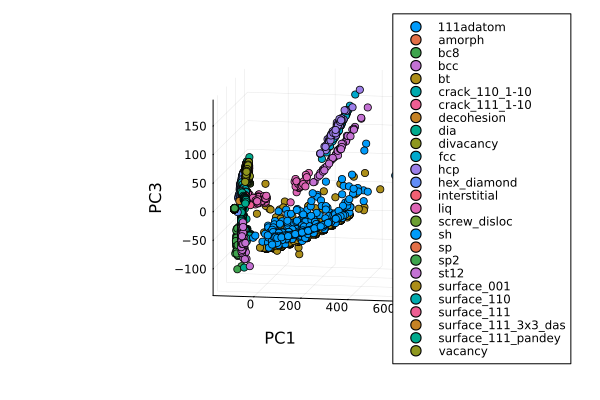

In [51]:
descriptors = []
for system in Si_dataset
    struct_descriptor = sum(site_descriptors(system, model)) / length(system)
    push!(descriptors, struct_descriptor)
end

descriptors = reduce(hcat, descriptors)  # convert to matrix
M = fit(PCA, descriptors; maxoutdim=3, pratio=1)
descriptors_trans = transform(M, descriptors)
p = scatter(
     descriptors_trans[1,:], descriptors_trans[2,:], descriptors_trans[3,:],
     marker=:circle, linewidth=0, group=config_types, legend=:right)
plot!(p, xlabel="PC1", ylabel="PC2", zlabel="PC3", camera=(10,10))

  ## Part 3: Basic model fitting

  We begin by defining an (extremely simple) ACEModel.

In [52]:
model = ace1_model(
              elements = [:Si,],
              order = 3,
              totaldegree = 8,
              rcut = 5.0,
              Eref = Dict(:Si => -158.54496821))

# `ace1_model` specifies a linear model `model`; because it is linear
# it is implicitly defined by a basis. In `ACEpotentials`, the size of
# this basis (= number of parameters) can be checked as follows
@show length_basis(model);

length_basis(model) = 62


  Next, we fit determine the model parameters using the tiny dataset and ridge
  regression via the QR solver.

In [53]:
solver = ACEfit.QR(lambda=1e-1)
data_keys = (energy_key = "dft_energy", force_key = "dft_force", virial_key = "dft_virial")
acefit!(Si_sub_data,  model;
        solver=solver, data_keys...);

@info("Training Errors")
compute_errors(Si_sub_data, model; data_keys...);
@info("Test Error")
compute_errors(Si_dataset, model; data_keys...);

┌───────────────┬──────────┬───────┬────┬─────┬─────┐
│          Type │ #Configs │ #Envs │ #E │  #F │  #V │
├───────────────┼──────────┼───────┼────┼─────┼─────┤
│ isolated_atom │        1 │     1 │  1 │   3 │   0 │
│           dia │       25 │    50 │ 25 │ 150 │ 150 │
│            bt │       25 │    50 │ 25 │ 150 │ 150 │
│           liq │        2 │   128 │  2 │ 384 │  12 │
├───────────────┼──────────┼───────┼────┼─────┼─────┤
│         total │       53 │   229 │ 53 │ 687 │ 312 │
│       missing │        0 │     0 │  0 │   0 │   6 │
└───────────────┴──────────┴───────┴────┴─────┴─────┘


┌ Info: Assembling linear problem.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:28
┌ Info:   - Creating feature matrix with size (1052, 62).
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:37
┌ Info:   - Beginning assembly with processor count:  1.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
┌ Info:   - Assembly completed.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:46
┌ Info: Assembling full weight vector.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:54
┌ Info: Training Errors
└ @ Main /Users/msachs2/Documents/GitHub-2/ACESIDopt.jl/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X55sZmlsZQ==.jl:6


┌───────────────┬─────────┬──────────┬─────────┐
│          Type │ E [meV] │ F [eV/A] │ V [meV] │
├───────────────┼─────────┼──────────┼─────────┤
│ isolated_atom │   0.000 │    0.000 │   0.000 │
│           dia │   9.639 │    0.121 │ 201.950 │
│           liq │   2.769 │    0.375 │  32.914 │
│            bt │  17.749 │    0.211 │ 302.074 │
├───────────────┼─────────┼──────────┼─────────┤
│           set │  13.882 │    0.302 │ 252.029 │
└───────────────┴─────────┴──────────┴─────────┘
┌───────────────┬─────────┬──────────┬─────────┐
│          Type │ E [meV] │ F [eV/A] │ V [meV] │
├───────────────┼─────────┼──────────┼─────────┤
│ isolated_atom │   0.000 │    0.000 │   0.000 │
│           dia │   6.612 │    0.093 │ 154.543 │
│           liq │   2.601 │    0.304 │  27.943 │
│            bt │  14.342 │    0.140 │ 209.775 │
├───────────────┼─────────┼──────────┼─────────┤
│           set │   9.982 │    0.221 │ 176.228 │
└───────────────┴─────────┴──────────┴─────────┘


┌ Info: RMSE Table
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/atoms_data.jl:378
┌ Info: MAE Table
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/atoms_data.jl:383
┌ Info: Test Error
└ @ Main /Users/msachs2/Documents/GitHub-2/ACESIDopt.jl/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X55sZmlsZQ==.jl:8


┌─────────────────────┬──────────┬──────────┬──────────┐
│                Type │  E [meV] │ F [eV/A] │  V [meV] │
├─────────────────────┼──────────┼──────────┼──────────┤
│                  sh │   20.267 │    0.117 │  165.913 │
│             vacancy │   14.585 │    0.221 │  131.728 │
│         surface_110 │  179.234 │    0.511 │    0.000 │
│                 sp2 │  794.615 │    0.447 │    0.000 │
│                 fcc │   94.982 │    0.325 │ 1192.146 │
│                  bt │   27.144 │    0.094 │  190.596 │
│      crack_110_1-10 │  132.270 │    0.585 │  211.893 │
│                 dia │   28.960 │    0.145 │  442.156 │
│           divacancy │   13.106 │    0.275 │    0.000 │
│        interstitial │   14.135 │    0.255 │   84.078 │
│                 hcp │  106.191 │    0.293 │ 1065.698 │
│ surface_111_3x3_das │  160.532 │    0.492 │    0.000 │
│              amorph │  118.278 │    0.428 │    0.000 │
│          decohesion │   15.487 │    0.347 │  145.726 │
│           111adatom │   51.21

┌ Info: RMSE Table
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/atoms_data.jl:378
┌ Info: MAE Table
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/atoms_data.jl:383


In [54]:
# using ACEpotentials: make_atoms_data
# using ACEfit
# data_keys = (energy_key = "dft_energy", force_key = "dft_force", virial_key = "dft_virial")
# default_weights() = Dict("default"=>Dict("E"=>30.0, "F"=>1.0, "V"=>1.0))
# data_train = make_atoms_data(Si_sub_data,  model; 
#                                 energy_key = data_keys.energy_key, 
#                                 force_key = data_keys.force_key, 
#                                 virial_key = data_keys.virial_key,
#                                 weights = default_weights()
#                                 )
# A_train, Y_train, W_train = ACEfit.assemble(data_train, model)

  Export to LAMMPS is currently not supported. Earlier versions of
  `ACEpotentials` supported this via
  ```julia
  export2lammps("model.yace", model)
  ```
  and some variant will likely be re-instated in the future.

  To save a model for future use within Julia, we can use

In [55]:
ACEpotentials.save_model(model, "Si_tiny_tutorial.json")

┌ Info: saving project
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/json_interface.jl:151
┌ Info: Results saved to file: Si_tiny_tutorial.json
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/json_interface.jl:167


  We can load the model again as follows.

In [56]:
m2, raw = ACEpotentials.load_model("Si_tiny_tutorial.json");

  Note that this requires us to work in the same (or a compatible) project
  environment. To guarantee that models can always be reconstructed we save a
  specification of the entire Julia environment together with the fitted
  model. This allows us to recover the exact project environment in case it is
  lost.

In [57]:
raw["manifest"]

JSON.Object{String, Any} with 4 entries:
  "deps"            => Object{String, Any}("SuiteSparse"=>Any[Object{String, An…
  "manifest_format" => "2.0"
  "julia_version"   => "1.11.7"
  "project_hash"    => "a2c1f970e0a80b61e6d8f864511acaeec51ad345"

  ## Part 4: Committee models

  `ACEpotentials.jl` can produce committee models using Bayesian linear
  regression. Such committees provide uncertainty estimates useful for active
  learning.

  Recall our two silicon datasets. We begin by training a (relatively small)
  model on the tiny version.

  Note the use of the BLR solver with a nonzero committee size.

In [58]:
model = ace1_model(elements = [:Si,],
                   Eref = [:Si => -158.54496821],
                   order = 3,
                   totaldegree = 8);

acefit!(Si_sub_data,  model;
        solver = ACEfit.BLR(committee_size = 30, factorization = :svd),
        energy_key = "dft_energy", force_key = "dft_force",
        verbose = false);

┌ Info: Assembling linear problem.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:28
┌ Info:   - Creating feature matrix with size (740, 62).
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:37
┌ Info:   - Beginning assembly with processor count:  1.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info:   - Assembly completed.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:46
┌ Info: Assembling full weight vector.
└ @ ACEfit /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/assemble.jl:54
┌ Info: Entering bayesian_linear_regression_svd
└ @ ACEfit.BayesianLinear /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/bayesianlinear.jl:434
┌ Info: Computing SVD of (740, 62) matrix
│   BLAS.get_num_threads() = 10
│   BLAS.get_config() = LBTConfig([ILP64] libopenblas64_.dylib)
└ @ ACEfit.BayesianLinear /Users/msachs2/.julia/packages

Iter     Function value   Gradient norm 
     0     8.802506e+02     5.057628e+02
 * time: 4.792213439941406e-5
     1     6.074364e+02     2.209670e+02
 * time: 0.0022258758544921875
     2     5.995931e+02     3.308820e+02
 * time: 0.0027980804443359375
     3     5.330773e+02     5.009028e+02
 * time: 0.0033440589904785156
     4     4.821145e+02     2.813843e+02
 * time: 0.003968000411987305
     5     4.627026e+02     5.842059e+01
 * time: 0.004370927810668945
     6     4.408016e+02     4.242622e+02
 * time: 0.00487208366394043
     7     3.920227e+02     6.183933e+02
 * time: 0.005449056625366211
     8     3.657280e+02     2.979254e+02
 * time: 0.006056070327758789
     9     3.607760e+02     4.642879e+01
 * time: 0.006459951400756836
    10     3.598226e+02     8.908405e+01
 * time: 0.006932973861694336
    11     3.575273e+02     2.389415e+01
 * time: 0.0075418949127197266
    12     3.574249e+02     7.340742e+00
 * time: 0.00801992416381836
    13     3.574195e+02     1.1499

┌ Info: Optimization complete
│   Results =  * Status: success

 * Candidate solution
    Final objective value:     3.574195e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.51e-12 ≤ 1.0e-08
    |x - x'|/|x'|          = 1.48e-13 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.27e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.36e-16 ≰ 0.0e+00
    |g(x)|                 = 2.82e-13 ≰ 0.0e+00

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    17
    f(x) calls:    63
    ∇f(x) calls:   63

└ @ ACEfit.BayesianLinear /Users/msachs2/.julia/packages/ACEfit/IRtHL/src/bayesianlinear.jl:487


  Next we define a function which assesses model performance on the full
  silicon dataset.

In [59]:
using AtomsCalculators: potential_energy

function assess_model(model, train_dataset)

    plot([-164,-157], [-164,-157]; lc=:black, label="")

    model_energies = []
    model_std = []
    for atoms in Si_dataset
        ene, co_ene = @committee potential_energy(atoms, model)
        push!(model_energies, ustrip(ene/length(atoms)))
        push!(model_std, ustrip(std(co_ene/length(atoms))))
    end
    rmse = sqrt(sum((model_energies-Si_dataset_energies).^2)/length(Si_dataset))
    mae = sum(abs.(model_energies-Si_dataset_energies))/length(Si_dataset)
    scatter!(Si_dataset_energies, model_energies;
             label="full dataset",
             title = @sprintf("Structures Used In Training:  %i out of %i\n", length(train_dataset), length(Si_dataset)) *
                     @sprintf("RMSE (MAE) For Entire Dataset:  %.0f (%.0f) meV/atom", 1000*rmse, 1000*mae),
             titlefontsize = 8,
             yerror = model_std,
             xlabel="Energy [eV/atom]", xlims=(-164,-157),
             ylabel="Model Energy [eV/atom]", ylims=(-164,-157),
             aspect_ratio = :equal, color=1)

    model_energies = [ustrip(potential_energy(atoms, model)/length(atoms)) for atoms in train_dataset]
    scatter!(extract_energies(train_dataset), model_energies;
             label="training set", color=2)

end;

  Applying this function to our current model yields

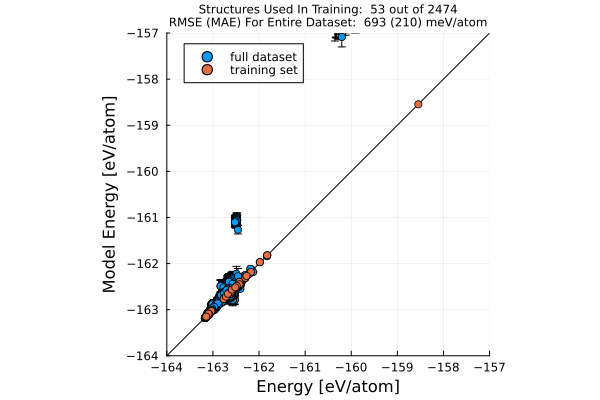

In [60]:
assess_model(model, Si_sub_data)

  Clearly there is room to improve: the model-derived RMSE is 280 meV/atom for
  the full dataset. Moreover, the error bars show the standard deviation of
  the energies predicted by the commmittee, which are quite high for some
  data.

  Next, we will define a function that augments the tiny dataset by adding
  structures for which the model is least confident.

In [61]:
function augment(old_dataset, old_model; num=5)

    new_dataset = deepcopy(old_dataset)
    new_model = deepcopy(old_model)

    model_std = []
    for atoms in Si_dataset
        ene, co_ene = @committee potential_energy(atoms, new_model)
        push!(model_std, ustrip( std(co_ene/length(atoms)) ))
    end
    for atoms in Si_dataset[sortperm(model_std; rev=true)[1:num]]
        push!(new_dataset, atoms)
    end
    @suppress acefit!(new_dataset, new_model;
            solver = ACEfit.BLR(committee_size=30, factorization=:svd),
            energy_key = "dft_energy", force_key = "dft_force",
            verbose = false);

    return new_dataset, new_model
end;

  The following applies this strategy, adding the five structures with the
  highest committee deviation.

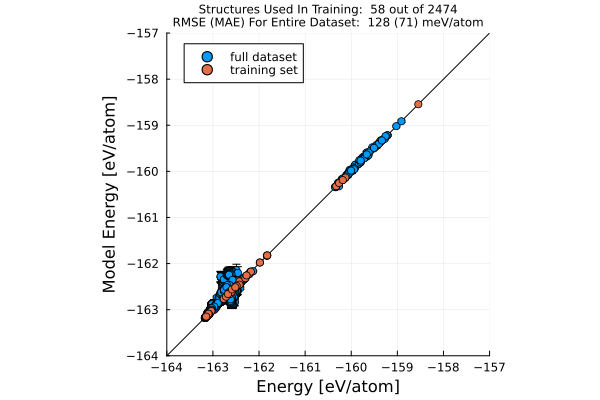

In [62]:
new_dataset, new_model = augment(Si_sub_data,  model; num=5);
assess_model(new_model, new_dataset)

  Already, there is notable improvement. The overall errors have dropped, and
  the predictions for the worst-performing structures are much improved.

  Next, we perform four additional augmentation steps, adding twenty
  structures in total.

i = 1
i = 2
i = 3
i = 4


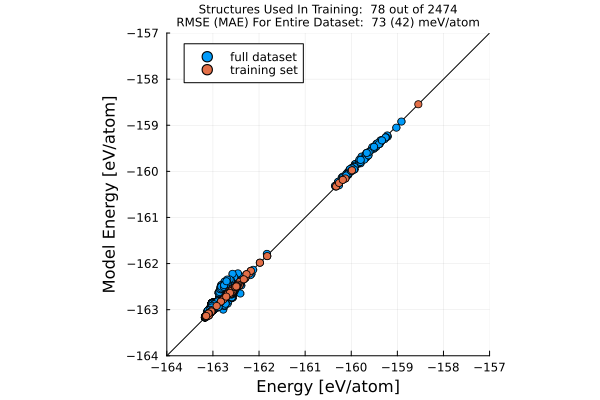

In [63]:
for i in 1:4
    global new_dataset, new_model # declare these are global variables
    @show i
    new_dataset, new_model = augment(new_dataset, new_model; num=5);
end
assess_model(new_model, new_dataset)

  Remarkably, although we are using only a small fraction (~3%) of the full
  dataset, our model now performs reasonably well.

  Further iterations may improve on this result; however, a larger model is
  necessary to obtain extremely low errors.

  Important: While this dataset filtering can be useful, the connection with
  active learning is crucial. Recall that we did not use the reference
  energies when selecting structures, only the committee deviation.

In [64]:
GC.gc()

In [69]:
ACEpotentials.save_model(model, "Si_ref_model-small-2.json") # degree = 8

┌ Info: saving project
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/json_interface.jl:151
┌ Info: Results saved to file: Si_ref_model-small-2.json
└ @ ACEpotentials /Users/msachs2/.julia/packages/ACEpotentials/nR4od/src/json_interface.jl:167


In [70]:
println("Total configurations in new_dataset: ", length(new_dataset))
println("\nConfiguration details:")
for (i, atoms) in enumerate(new_dataset)
    config_type = haskey(atoms, :config_type) ? atoms[:config_type] : "unknown"
    println("Config $i: size = ", length(atoms), " atoms, type = ", config_type)
end

println("\nSummary by config_type:")
new_config_types = [haskey(at, :config_type) ? at[:config_type] : "unknown" for at in new_dataset]
display(count_configs(new_config_types))

Dict{String, Int64} with 11 entries:
  "sp"                  => 6
  "liq"                 => 2
  "sh"                  => 1
  "sp2"                 => 5
  "bt"                  => 25
  "surface_111"         => 4
  "isolated_atom"       => 1
  "dia"                 => 28
  "hcp"                 => 2
  "bcc"                 => 3
  "surface_111_3x3_das" => 1

Total configurations in new_dataset: 78

Configuration details:
Config 1: size = 1 atoms, type = isolated_atom
Config 2: size = 2 atoms, type = dia
Config 3: size = 2 atoms, type = dia
Config 4: size = 2 atoms, type = dia
Config 5: size = 2 atoms, type = dia
Config 6: size = 2 atoms, type = dia
Config 7: size = 2 atoms, type = dia
Config 8: size = 2 atoms, type = dia
Config 9: size = 2 atoms, type = dia
Config 10: size = 2 atoms, type = dia
Config 11: size = 2 atoms, type = dia
Config 12: size = 2 atoms, type = dia
Config 13: size = 2 atoms, type = dia
Config 14: size = 2 atoms, type = dia
Config 15: size = 2 atoms, type = dia
Config 16: size = 2 atoms, type = dia
Config 17: size = 2 atoms, type = dia
Config 18: size = 2 atoms, type = dia
Config 19: size = 2 atoms, type = dia
Config 20: size = 2 atoms, type = dia
Config 21: size = 2 atoms, type = dia
Config 22: size = 2 atoms, type = dia
Config 23: size = 2 atoms, type = dia
Config 24: size = 2 atoms, type = dia
Config 25: size = 2 ato

In [71]:
ExtXYZ.save("Si_reef_model-small-train-data-2.xyz", new_dataset)

In [74]:
diamond_configs = [at for at in new_dataset if haskey(at, :config_type) && at[:config_type] == "dia"]
println("Found ", length(diamond_configs), " diamond configurations")
ExtXYZ.save("../data/Si-diamond-ref.xyz", diamond_configs)

Found 28 diamond configurations
